<a href="https://colab.research.google.com/github/GemmaGorey/Dissertation/blob/main/Audio_Processing_V2_Dissertation_GG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Initial Colab setup below - Run  top two cells once only per session**


In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()
# install mamba to use instead of pip

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


In [1]:
# Create the config file and build the environment.
yaml_content = """
name: dissertation
channels:
  - pytorch
  - conda-forge
dependencies:
  - python=3.11
  - pytorch=2.2.2
  - torchvision=0.17.2
  - torchaudio
  - librosa
  - numpy<2
  - pandas
  - jupyter
  - wandb
"""

# Write the string content to a file -  'environment.yml'.
with open('environment.yml', 'w') as f:
    f.write(yaml_content)

print("environment.yml file created successfully.")

# create the environment using mamba from the yml file.
print("\n Creating environment")

!mamba env create -f environment.yml --quiet && echo -e "\n 'dissertation' environment is ready to use."

environment.yml file created successfully.

 Creating environment
Channels:
 - pytorch
 - conda-forge
Platform: linux-64
Solving environment: ...working... done
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

 'dissertation' environment is ready to use.


In [2]:
# imports and setting up of GitHub and W&B

# clone project repository from GitHub
print("⏳ Cloning GitHub repository...")
!git clone https://github.com/GemmaGorey/Dissertation.git
print("Repository cloned.")

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#imports
import pandas as pd
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from transformers import AutoTokenizer
from tqdm.auto import tqdm
import torch
import glob

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased') #loading the tokenizer for lyrics processing
print("Tokenizer loaded.")

⏳ Cloning GitHub repository...
Cloning into 'Dissertation'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 228 (delta 95), reused 64 (delta 47), pack-reused 81 (from 2)
Receiving objects: 100% (228/228), 2.18 MiB | 9.53 MiB/s, done.
Resolving deltas: 100% (110/110), done.
Repository cloned.
Mounted at /content/drive
Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded.


In [3]:
#loading in the dataset -using complete which has the lyrics and music.

# create string for path to where dataset lives
data_path = '/content/drive/MyDrive/dissertation/audio/'

# load the files

print("Loading MERGE Metadata ")
merge_df = pd.read_csv(data_path + 'merge_bimodal_complete_metadata.csv')

print("\n Loading Valence-Arousal values")
av_df = pd.read_csv(data_path + 'merge_bimodal_complete_av_values.csv')


print("\n Datasets loaded successfully.")

# Inspect the files
print("\n First 5 rows of the data")
display(merge_df.head())

print("\n First 5 rows of the MERGE AV Values")
display(av_df.head())

Loading MERGE Metadata 

 Loading Valence-Arousal values

 Datasets loaded successfully.

 First 5 rows of the data


,Audio_Song,Lyric_Song,Quadrant,AllMusic Id,AllMusic Extraction Date,Artist,Title,Relevance,Year,LowestYear,...,ThemeWeights,Styles,StyleWeights,AppearancesTrackIDs,AppearancesAlbumIDs,Sample,SampleURL,ActualYear,num_Genres,num_MoodsAll
0,A001,L051,Q4,MT0000291374,New,Louis Armstrong,What a Wonderful World,NaN,NaN,NaN,...,"9,9",NaN,NaN,NaN,NaN,NaN,NaN,1968,NaN,NaN
1,A002,L052,Q4,MT0001577585,Old,Rod Stewart,Country Comfort,1.493585,1970-??-??,NaN,...,"5,5,5,5,5,5,5,5","Adult Contemporary,Contemporary Pop/Rock","5,5","MT0001577585,MT0002372349,MT0002706336,MT00029...","MW0000073575,MW0000100670,MW0000100670,MW00001...",1.0,http://rovimusic.rovicorp.com/playback.mp3?c=s...,1970,NaN,NaN
2,A003,L053,Q3,MT0008469560,New,Stevie Wonder,Lately,NaN,NaN,NaN,...,"7,8,9,9,9",NaN,NaN,NaN,NaN,NaN,NaN,1980,NaN,NaN
3,A004,L054,Q3,MT0030326044,New,Johnny Cash,I'm So Lonesome I Could Cry,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960,NaN,NaN
4,A005,L055,Q1,MT0005204984,New,Prince,U Got the Look,NaN,NaN,NaN,...,"8,8,8,9,9,9",NaN,NaN,NaN,NaN,NaN,NaN,1987,NaN,NaN



 First 5 rows of the MERGE AV Values


,Audio_Song,Lyric_Song,Arousal,Valence
0,A001,L051,0.29375,0.89375
1,A002,L052,0.33750,0.68125
2,A003,L053,0.25000,0.22500
3,A004,L054,0.20000,0.18125
4,A005,L055,0.78750,0.68750


In [4]:
# merging the two dataframes using the common column

final_df = pd.merge(merge_df, av_df, left_on='Audio_Song', right_on='Audio_Song')

print(" DataFrames merged")

print("\n First 5 rows  MASTER DataFrame")
display(final_df.head())

 DataFrames merged

 First 5 rows  MASTER DataFrame


,Audio_Song,Lyric_Song_x,Quadrant,AllMusic Id,AllMusic Extraction Date,Artist,Title,Relevance,Year,LowestYear,...,AppearancesTrackIDs,AppearancesAlbumIDs,Sample,SampleURL,ActualYear,num_Genres,num_MoodsAll,Lyric_Song_y,Arousal,Valence
0,A001,L051,Q4,MT0000291374,New,Louis Armstrong,What a Wonderful World,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1968,NaN,NaN,L051,0.29375,0.89375
1,A002,L052,Q4,MT0001577585,Old,Rod Stewart,Country Comfort,1.493585,1970-??-??,NaN,...,"MT0001577585,MT0002372349,MT0002706336,MT00029...","MW0000073575,MW0000100670,MW0000100670,MW00001...",1.0,http://rovimusic.rovicorp.com/playback.mp3?c=s...,1970,NaN,NaN,L052,0.33750,0.68125
2,A003,L053,Q3,MT0008469560,New,Stevie Wonder,Lately,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1980,NaN,NaN,L053,0.25000,0.22500
3,A004,L054,Q3,MT0030326044,New,Johnny Cash,I'm So Lonesome I Could Cry,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1960,NaN,NaN,L054,0.20000,0.18125
4,A005,L055,Q1,MT0005204984,New,Prince,U Got the Look,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1987,NaN,NaN,L055,0.78750,0.68750


In [5]:
#checking data - in different quadrants
print(final_df['Quadrant'].value_counts())

Quadrant
Q2    673
Q1    525
Q4    518
Q3    500
Name: count, dtype: int64


In [6]:
#checking data
print(final_df[['Valence', 'Arousal']].describe())

           Valence      Arousal
count  2216.000000  2216.000000
mean      0.505027     0.482316
std       0.231149     0.139533
min       0.018750     0.062500
25%       0.293750     0.370625
50%       0.398750     0.506250
75%       0.738906     0.578750
max       0.987500     0.975000


In [7]:
#checking no blank entries
print(final_df[['Quadrant', 'Valence', 'Arousal']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Quadrant  2216 non-null   object 
 1   Valence   2216 non-null   float64
 2   Arousal   2216 non-null   float64
dtypes: float64(2), object(1)
memory usage: 52.1+ KB
None


In [9]:
#global parameters for the audio processing

TARGET_SR = 22050 #used in the AllMusic dataset, which is where this original data is from.(may try 16k to see if it lowers accuracy)
N_FFT = 2048#  using Librosa's (for music) standard values but can change to test
HOP_LENGTH = 512 # using Librosa's (for music) standard values but can change to test
N_MELS = 128 # using Librosa's (for music) standard values but can change to test

def find_global_max_power(dataframe, base_audio_path):
    """
    Loops through all audio files in the audio dataframe to find the
    single maximum power value in any Mel spectrogram. This is used as a form of normalisation
    """
    print("Finding global max")
    # Start off with a very small number
    global_max_power = -np.inf

    # Use tqdm for a progress bar
    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        try:
            song_id = row['Audio_Song']
            quadrant = row['Quadrant']

            # Construct the audio file path
            audio_path = os.path.join(base_audio_path, quadrant, f"{song_id}.mp3")

            # Load audio
            y, sr = librosa.load(audio_path, sr=TARGET_SR)

            # Get spectrogram using the global variables
            mel_spec_power = librosa.feature.melspectrogram(
                y=y,
                sr=sr,
                n_fft=N_FFT,
                hop_length=HOP_LENGTH,
                n_mels=N_MELS
            )

            # Find max in each one
            current_max_power = np.max(mel_spec_power)

            # Update global max if this is higher
            if current_max_power > global_max_power:
                global_max_power = current_max_power

        except Exception as e:
            print(f"\nSkipping file {song_id} due to error: {e}")

    print("\n Global max found")
    return global_max_power




In [11]:
GLOBAL_MAX = find_global_max_power(final_df, data_path)

Finding global max


  0%|          | 0/2216 [00:00<?, ?it/s]


 Global max found


In [12]:
print(GLOBAL_MAX)
print(GLOBAL_MIN)

13400.846


In [18]:
GLOBAL_MAX = 13400.846

#Output from before so don't have to run each time - This is the power output max

In [16]:
def find_global_max_and_outlier(dataframe, base_audio_path):
    """
    Loops through all audio files to find the single maximum power value
    and prints the song ID responsible for each new maximum.
    """

    # Start off with a very small number
    global_max_power = -np.inf
    outlier_file = "None"
    outlier_quadrant = "None"

    # Use tqdm for a progress bar
    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        try:
            song_id = row['Audio_Song']
            quadrant = row['Quadrant']

            # Construct the audio file path
            audio_path = os.path.join(base_audio_path, quadrant, f"{song_id}.mp3")

            # Load audio
            y, sr = librosa.load(audio_path, sr=TARGET_SR)

            # Check for silent/corrupt files
            if np.max(np.abs(y)) < 0.001:
                # This skips (near) silent files, which can also be a problem
                continue

            # Get spectrogram using the global variables
            mel_spec_power = librosa.feature.melspectrogram(
                y=y,
                sr=sr,
                n_fft=N_FFT,
                hop_length=HOP_LENGTH,
                n_mels=N_MELS
            )

            # Find max in each one
            current_max_power = np.max(mel_spec_power)

            # Update global max if this is higher
            if current_max_power > global_max_power:
                global_max_power = current_max_power
                outlier_file = song_id
                outlier_quadrant = quadrant
                print(f"\nNew Max Found: {global_max_power:.2f}")
                print(f"   (From Song ID: {outlier_file} in Quadrant: {outlier_quadrant})")

        except Exception as e:
            # This will also catch corrupt files that librosa can't even load
            print(f"\nSKIPPING FILE {song_id} due to error: {e}")

    print("\nComplete")
    print(f"The HIGHEST max power was: {global_max_power:.2f}")
    print(f"This value came from the file: {outlier_file} (Quadrant: {outlier_quadrant})")

    return global_max_power, outlier_file

    #DECIDED OFF THE BACK OF THIS EXPERIMENT NOT TO USE THE GLOBAL MAX. PUSHES THE SCALE TO NEGATIVE WHICH IS NEARER THE FLOOR OF -80.

In [17]:
GLOBAL_MAX_OUTLIER = find_global_max_and_outlier(final_df, data_path)

  0%|          | 0/2216 [00:00<?, ?it/s]


New Max Found: 521.81
   (From Song ID: A001 in Quadrant: Q4)

New Max Found: 735.90
   (From Song ID: A002 in Quadrant: Q4)

New Max Found: 2500.21
   (From Song ID: A010 in Quadrant: Q2)

New Max Found: 3837.99
   (From Song ID: A022 in Quadrant: Q1)

New Max Found: 6791.26
   (From Song ID: A043 in Quadrant: Q1)

New Max Found: 6827.36
   (From Song ID: A128-109 in Quadrant: Q1)

New Max Found: 10066.23
   (From Song ID: A131-101 in Quadrant: Q2)

New Max Found: 13400.85
   (From Song ID: MT0004073991 in Quadrant: Q2)

Complete
The HIGHEST max power was: 13400.85
This value came from the file: MT0004073991 (Quadrant: Q2)


In [26]:
def load_song_data(song_id, lyric_id, quadrant):
    """
    Loads the audio and lyrics for a given song ID
    """
    print(f"Attempting to load song: {song_id}")
    try:
        # Construct the file path to google drive
        base_path = '/content/drive/MyDrive/dissertation/'

        # Audio files url addition as these are in subfolders for each emotion quadrant
        audio_path = os.path.join(base_path, 'audio', quadrant, f"{song_id}.mp3")

        # Lyric files url addition as these are in a separate main folder
        lyrics_path = os.path.join(base_path, 'lyrics', quadrant, f"{lyric_id}.txt")

        # load the audio file
        audio_waveform, sample_rate = librosa.load(audio_path, sr=TARGET_SR)

        #Process Audio into a Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_waveform, sr=sample_rate, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)

        # Convert to decibels
        db_spectrogram = librosa.power_to_db(mel_spectrogram, ref=1.0)

        target_length = 1292  # A fixed length for all spectrograms, so same length tensors later - chosen for 30 seconds, and sr of 22050, and hop_length of 512
        current_length = db_spectrogram.shape[1]

        if current_length > target_length:
            # If it is too long, truncate it
            db_spectrogram = db_spectrogram[:, :target_length]
        elif current_length < target_length:
            # If too short, pad it
            padding_needed = target_length - current_length
            db_spectrogram = np.pad(db_spectrogram,
                                    ((0, 0), (0, padding_needed)),
                                    mode='constant',
                                    constant_values=-80.0) #close to silence so doesn't impact

        # load lyrics text
        with open(lyrics_path, 'r', encoding='utf-8') as f:
            lyrics_text = f.read()

        #Tokenise raw text
        encoded_lyrics = tokenizer(
            lyrics_text,
            padding='max_length',
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )

        print(f"Successfully loaded and processed {song_id}")
        #returns the spectrogram and the tokenised lyrics
        return db_spectrogram, encoded_lyrics

    except Exception as e:
        print(f"An error occurred for {song_id}: {e}")
        return None, None


Audio ID: MT0006531857
Lyric ID: MT0006531857
Quadrant: Q2
Attempting to load song: MT0006531857
Successfully loaded and processed MT0006531857

--- Tokenized Lyrics Output ---
Encoded Tensors:


{'input_ids': tensor([[  101,  1997,  8714,  1998,  8714,  2066,  1037, 11689,  1997,  6804,
          6953,  6532,  2013,  1996,  2353,  3239, 19262,  2943,  2207,  2013,
          1996,  2568,  1010,  7302,  2000,  1996,  2455,  1997,  1996,  7160,
         23172,  3357,  1999,  1996, 13576, 22774,  2182,  4832,  1996,  1062,
          8004, 27390,  4017, 21305, 12123,  7302,  2000,  8714,  1005,  1055,
          9812, 12702,  1011, 14448, 11305,  1997,  1996,  2534, 14194, 19185,
          4432,  1037,  2088,  1997, 27906,  1006,  1998,  1007,  2061, 19170,
          2854,  2391,  1996,  8782, 16681,  2012,  2017, 13769,  8754,  1997,
          1996, 13374,  7487,  1996,  7619,  3606,  1037,  2088,  2007, 27906,
          1006,  1998,  1007,  2061, 19170,  2854, 13769,  8754,  1997,  1996,
         18823,  2391,  1996, 16681,  2012,  2017,  2009,  1005,  1055,  2035,
          1999,  1037,  4418,  2009,  1005,  1055,  2035,  2306,  1996,  9546,
          4949,  1996,  6731,  3011,  


Sample of Tokens Produced:
['[CLS]', 'of', 'mercury', 'and', 'mercury', 'like', 'a', 'thread', 'of', 'spider', 'silk', 'burst', 'from', 'the', 'third', 'eye', 'inverse', 'energy', 'released', 'from', 'the', 'mind', ',', 'pointing', 'to', 'the', 'land', 'of', 'the', 'delta', 'prophets', 'step', 'in', 'the', 'bizarre', 'bazaar', 'here', 'stands', 'the', 'z', '##ig', '##gur', '##at', 'bursting', 'plasma', 'pointing', 'to', 'mercury', "'", 's']

--- Spectrogram Data ---
Shape: (128, 1292)

Displaying Spectrogram:


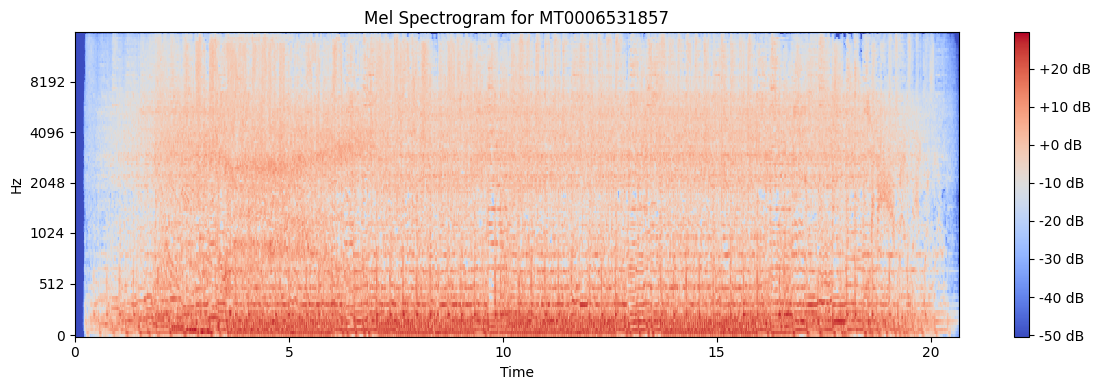

In [27]:

#testing the output of the above function by picking a song.

#pick a song between 0 and 2215
test_song_index = 1111

test_audio_id = final_df.iloc[test_song_index]['Audio_Song']
test_lyric_id = final_df.iloc[test_song_index]['Lyric_Song_x']
test_quadrant = final_df.iloc[test_song_index]['Quadrant']

print(f"Audio ID: {test_audio_id}")
print(f"Lyric ID: {test_lyric_id}")
print(f"Quadrant: {test_quadrant}")

#variables for the spectorgram and tokenised lyrics loaded.
spectrogram, encoded_lyrics = load_song_data(test_audio_id, test_lyric_id, test_quadrant)


#check the output of the lyrics
if encoded_lyrics is not None:
    print("\n--- Tokenized Lyrics Output ---")

    #dictionary of tensors
    print("Encoded Tensors:")
    display(encoded_lyrics)

    #readable tokens to check
    tokens = tokenizer.convert_ids_to_tokens(encoded_lyrics['input_ids'][0])

    print("\nSample of Tokens Produced:")
    print(tokens[:50])

#check the output of the audio
if spectrogram is not None:
    print("\n--- Spectrogram Data ---")
    print(f"Shape: {spectrogram.shape}")

    #show spectogram
    print("\nDisplaying Spectrogram:")
    plt.figure(figsize=(12, 4))
    #get the sample rate for the axis display
    audio_file_path = os.path.join('/content/drive/MyDrive/dissertation/audio', test_quadrant, f'{test_audio_id}.mp3')
    sr = librosa.get_samplerate(path=audio_file_path)

    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')

    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram for {test_audio_id}')
    plt.tight_layout()
    plt.show()

In [22]:

#define where to save the files
base_path = '/content/drive/MyDrive/dissertation/merge_dataset/output_from_code/'
spectrogram_save_dir = os.path.join(base_path, 'processed_spectrograms/')
lyrics_save_dir = os.path.join(base_path, 'processed_lyrics/')

# Create the directories if they don't exist
os.makedirs(spectrogram_save_dir, exist_ok=True)
os.makedirs(lyrics_save_dir, exist_ok=True)

print(f"Spectrograms will be saved in: {spectrogram_save_dir}")
print(f"Lyric tensors will be saved in: {lyrics_save_dir}")

#process the audio and lyrics storing info as processed
processed_records = []

#iterate over all rows and get origress bar
for index, row in tqdm(final_df.iterrows(), total=final_df.shape[0], desc="Processing Songs"):

    #get song info from each row
    song_id = row['Audio_Song']
    lyric_id = row['Lyric_Song_x']
    quadrant = row['Quadrant']

    #call function to transform
    spectrogram, encoded_lyrics = load_song_data(song_id, lyric_id, quadrant)

    #check if it worked
    if spectrogram is not None and encoded_lyrics is not None:
        try:
            #save the spectorgram
            spectrogram_path = os.path.join(spectrogram_save_dir, f"{song_id}.npy")
            np.save(spectrogram_path, spectrogram)

            #save tokenised lyric tensors
            lyrics_path = os.path.join(lyrics_save_dir, f"{song_id}.pt")
            torch.save(encoded_lyrics, lyrics_path)

            #record file path
            processed_records.append({
                'song_id': song_id,
                'spectrogram_path': spectrogram_path,
                'lyrics_path': lyrics_path,
                'valence': row['Valence'],
                'arousal': row['Arousal'],
                'quadrant': quadrant
            })
        except Exception as e:
            print(f"Error saving files for {song_id}: {e}")


#save new dataframe for using in experiments
processed_df = pd.DataFrame(processed_records)
master_file_path = os.path.join(base_path, 'master_processed_file_list.csv')
processed_df.to_csv(master_file_path, index=False)

print("\n PROCESSING COMPLETE!")
print(f"Saved {len(processed_df)} records.")
print(f"Master file list saved to: {master_file_path}")
display(processed_df.head())

Spectrograms will be saved in: /content/drive/MyDrive/dissertation/merge_dataset/output_from_code/processed_spectrograms/
Lyric tensors will be saved in: /content/drive/MyDrive/dissertation/merge_dataset/output_from_code/processed_lyrics/


Processing Songs:   0%|          | 0/2216 [00:00<?, ?it/s]

Attempting to load song: A001
Successfully loaded and processed A001
Attempting to load song: A002
Successfully loaded and processed A002
Attempting to load song: A003
Successfully loaded and processed A003
Attempting to load song: A004
Successfully loaded and processed A004
Attempting to load song: A005
Successfully loaded and processed A005
Attempting to load song: A010
Successfully loaded and processed A010
Attempting to load song: A011
Successfully loaded and processed A011
Attempting to load song: A013
Successfully loaded and processed A013
Attempting to load song: A014
Successfully loaded and processed A014
Attempting to load song: A017
Successfully loaded and processed A017
Attempting to load song: A018
Successfully loaded and processed A018
Attempting to load song: A019
Successfully loaded and processed A019
Attempting to load song: A020
Successfully loaded and processed A020
Attempting to load song: A021
Successfully loaded and processed A021
Attempting to load song: A022
Succ

KeyboardInterrupt: 

In [ ]:

#path to where this was saved
base_path = '/content/drive/MyDrive/dissertation/output_from_code/'
master_file_path = os.path.join(base_path, 'master_processed_file_list.csv')

#load the master csv with all the paths and VA values
master_df = pd.read_csv(master_file_path)

print("Master csv loaded")
display(master_df.head())

#check data for 1 song
#pick a song between 0 and 2215
test_final_song_index = 1111
song_info = master_df.iloc[test_final_song_index]

print(f"\n--- Loading data for song: {song_info['song_id']} ---")

#Load the spectrogram from the file
spectrogram = np.load(song_info['spectrogram_path'])

#load the lyric tensors
encoded_lyrics = torch.load(song_info['lyrics_path'], weights_only=False)

#Get the labels
valence = song_info['valence']
arousal = song_info['arousal']

#check the data
print("Spectrogram Shape:", spectrogram.shape)
print("Encoded Lyrics Tensors:", encoded_lyrics)
print(f"Labels - Valence: {valence}, Arousal: {arousal}")
